In [1]:
import pandas as pd
import numpy as np
import kaggle
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

%matplotlib inline

In [2]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('titanic', path='./titanic_data')

with zipfile.ZipFile('./titanic_data/titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('./titanic_data')

os.remove('./titanic_data/titanic.zip')

train_df = pd.read_csv('./titanic_data/train.csv')
test_df = pd.read_csv('./titanic_data/test.csv')

In [3]:
# Selection of variables
train_df = train_df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]

train_df['Survived_str'] = train_df['Survived'].map({0: 'No', 1: 'Yes'})
train_df['Sex_int'] = train_df['Sex'].map({'male': 0, 'female': 1})

train_df = train_df[['Survived', 'Survived_str', 'Sex', 'Sex_int', 'Age', 'Pclass', 'Fare']]

print(train_df.head(15))

    Survived Survived_str     Sex  Sex_int   Age  Pclass     Fare
0          0           No    male        0  22.0       3   7.2500
1          1          Yes  female        1  38.0       1  71.2833
2          1          Yes  female        1  26.0       3   7.9250
3          1          Yes  female        1  35.0       1  53.1000
4          0           No    male        0  35.0       3   8.0500
5          0           No    male        0   NaN       3   8.4583
6          0           No    male        0  54.0       1  51.8625
7          0           No    male        0   2.0       3  21.0750
8          1          Yes  female        1  27.0       3  11.1333
9          1          Yes  female        1  14.0       2  30.0708
10         1          Yes  female        1   4.0       3  16.7000
11         1          Yes  female        1  58.0       1  26.5500
12         0           No    male        0  20.0       3   8.0500
13         0           No    male        0  39.0       3  31.2750
14        

In [4]:
# How many NA?
print(train_df.isna().sum())
print(' ')
print(train_df.isna().mean() * 100)  # %

Survived          0
Survived_str      0
Sex               0
Sex_int           0
Age             177
Pclass            0
Fare              0
dtype: int64
 
Survived         0.00000
Survived_str     0.00000
Sex              0.00000
Sex_int          0.00000
Age             19.86532
Pclass           0.00000
Fare             0.00000
dtype: float64


In [5]:
print(train_df.describe())

         Survived     Sex_int         Age      Pclass        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000
mean     0.383838    0.352413   29.699118    2.308642   32.204208
std      0.486592    0.477990   14.526497    0.836071   49.693429
min      0.000000    0.000000    0.420000    1.000000    0.000000
25%      0.000000    0.000000   20.125000    2.000000    7.910400
50%      0.000000    0.000000   28.000000    3.000000   14.454200
75%      1.000000    1.000000   38.000000    3.000000   31.000000
max      1.000000    1.000000   80.000000    3.000000  512.329200


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

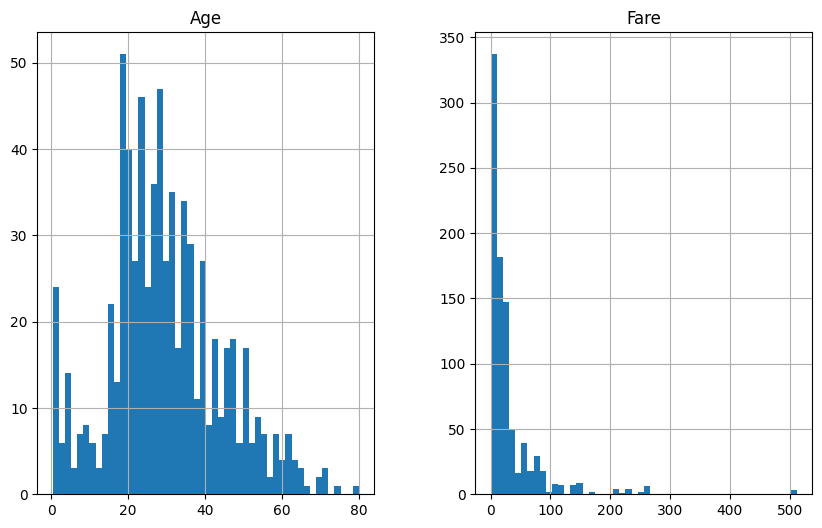

In [6]:
train_df[['Age', 'Fare']].hist(bins=50, figsize=(10, 6))

In [7]:
train_df['Fare_log'] = np.log1p(train_df['Fare'])

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare_log'}>]], dtype=object)

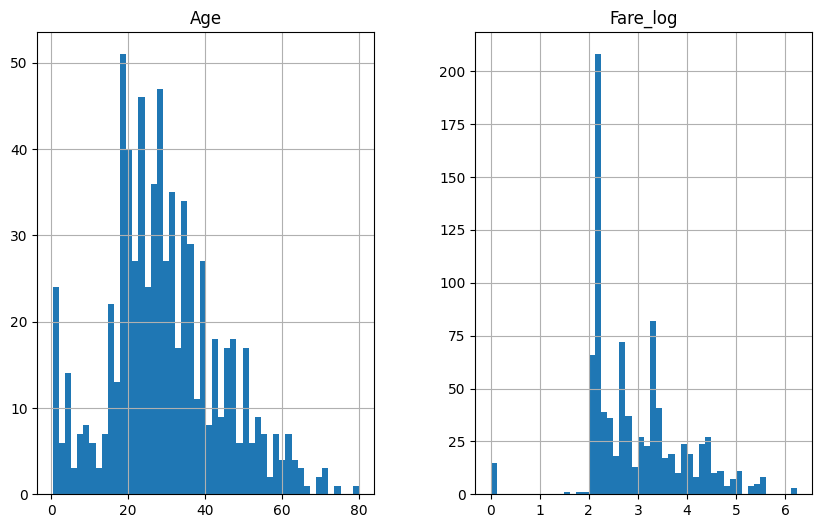

In [8]:
train_df[['Age', 'Fare_log']].hist(bins=50, figsize=(10, 6))

---

### Bilding logistic regression model

Let’s check the correlation of our variables

In [9]:
corr_matrix = train_df[['Survived', 'Pclass', 'Sex_int', 'Age', 'Fare_log']].corr()
print(corr_matrix["Survived"].sort_values(ascending=False))

Survived    1.000000
Sex_int     0.543351
Fare_log    0.329862
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64


Add the interaction between the class of the ticket and the passenger’s gender

In [10]:
train_df = train_df[['Survived', 'Pclass', 'Sex_int', 'Fare_log']]
train_df['Pclass*Sex_int'] = train_df['Pclass'] * train_df['Sex_int']

Model by statsmodels

In [11]:
import statsmodels.api as sm

x = train_df[['Pclass', 'Sex_int', 'Fare_log', 'Pclass*Sex_int']]
y = train_df['Survived']

x = sm.add_constant(x)

model = sm.Logit(y, x)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.450345
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            4
Date:                Tue, 19 Aug 2025   Pseudo R-squ.:                  0.3237
Time:                        11:35:09   Log-Likelihood:                -401.26
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 7.428e-82
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4230      0.612     -0.691      0.489      -1.622       0.776
Pclass           

Passenger fare was found to be an insignificant feature

In [12]:
print('Log-odds (coefficients)')
print(result.params[['Pclass', 'Sex_int', 'Pclass*Sex_int']])
print(' ')
print("Odds ratios:")
odds_ratios = np.exp(result.params)
print(odds_ratios[['Pclass', 'Sex_int', 'Pclass*Sex_int']])
print(' ')
percent_change = (odds_ratios - 1) * 100
print("Percent change in odds:")
print(percent_change[['Pclass', 'Sex_int', 'Pclass*Sex_int']])

Log-odds (coefficients)
Pclass           -0.577606
Sex_int           6.041442
Pclass*Sex_int   -1.365683
dtype: float64
 
Odds ratios:
Pclass              0.561240
Sex_int           420.498890
Pclass*Sex_int      0.255206
dtype: float64
 
Percent change in odds:
Pclass              -43.875964
Sex_int           41949.888961
Pclass*Sex_int      -74.479361
dtype: float64


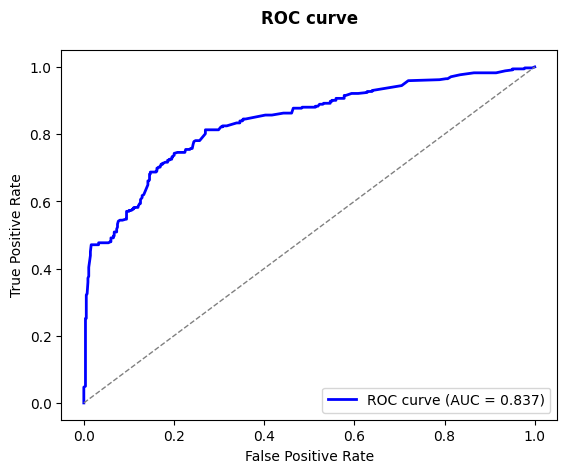

In [13]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = result.predict(x)
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # линия случайного классификатора
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve', fontweight='bold', y=1.05)
plt.legend(loc="lower right")
plt.show()

The model classifies passengers fairly well

In [14]:
print(f"McFadden R²: {result.prsquared:.3f}")

McFadden R²: 0.324


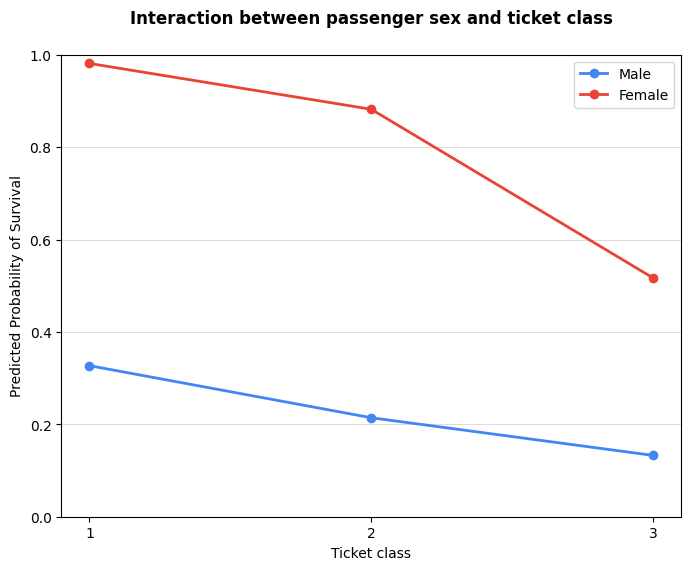

In [15]:
b = result.params

fare_mean = train_df['Fare_log'].mean()

pclass_vals = [1, 2, 3]
sex_vals = [0, 1]
colors = {'Male': '#4285F4', 'Female': '#EA4335'}

plt.figure(figsize=(8,6))

plt.grid(True, axis='y', alpha=0.6, linestyle='-', linewidth=0.5)

for s in sex_vals:
    probs = []
    for p in pclass_vals:
        logit = (b['const']
                + b['Pclass'] * p
                + b['Sex_int'] * s
                + b['Fare_log'] * fare_mean
                + b['Pclass*Sex_int'] * (p * s))
        prob = 1 / (1 + np.exp(-logit))
        probs.append(prob)
    
    label = 'Female' if s == 1 else 'Male'
    
    plt.plot(pclass_vals, probs, marker='o', label=label, 
             linewidth=2, color=colors[label])

plt.xlabel('Ticket class')
plt.ylabel('Predicted Probability of Survival')
plt.title('Interaction between passenger sex and ticket class',
          fontweight='bold', y=1.05)
plt.legend()
plt.xticks([1, 2, 3])
plt.ylim(0, 1)
plt.show()

First-class women are almost guaranteed to survive, but third-class men are almost always died

---

### Use our model

In [16]:
test_df['Fare_log'] = np.log1p(test_df['Fare'])
test_df['Sex_int'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df['Pclass*Sex_int'] = test_df['Pclass'] * test_df['Sex_int']

X_test = test_df[['Pclass', 'Sex_int', 'Fare_log', 'Pclass*Sex_int']]
X_test = sm.add_constant(X_test)

With probability > 0.5 will be assigned 1 (Survivor)

In [17]:
survival_probabilities = result.predict(X_test)
survival_predictions = (survival_probabilities > 0.5).astype(int)

test_df['Survived_pred'] = survival_predictions
test_df['Survived_prob'] = survival_probabilities

In [18]:
print(test_df[['Sex', 'Pclass', 'Age', 'Survived_pred', 'Survived_prob']].head(20))

       Sex  Pclass   Age  Survived_pred  Survived_prob
0     male       3  34.5              0       0.124455
1   female       3  47.0              0       0.496052
2     male       2  62.0              0       0.205001
3     male       3  27.0              0       0.125382
4   female       3  22.0              1       0.507986
5     male       3  14.0              0       0.125967
6   female       3  30.0              0       0.497833
7     male       2  26.0              0       0.221281
8   female       3  18.0              0       0.496717
9     male       3  21.0              0       0.135590
10    male       3   NaN              0       0.124532
11    male       1  46.0              0       0.333916
12  female       1  23.0              1       0.983556
13    male       2  63.0              0       0.219577
14  female       1  47.0              1       0.983105
15  female       2  24.0              1       0.885721
16    male       2  35.0              0       0.208433
17    male